In [32]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import xarray as xr
from AOSCMcoupling.files import NEMOPreprocessor, OIFSPreprocessor
import proplot as pplt

In [2]:
max_iters = 30
alpha = 0.25

In [33]:
def load_iterates(
    file_name: str,
    preprocess: callable,
    max_iters: int,
    dir: Path,
    exp_id: str,
) -> xr.Dataset:
    assert Path(dir).is_dir()
    swr_dim = xr.DataArray(np.arange(max_iters) + 1, dims="swr_iterate")
    iterates = [
        xr.open_mfdataset(f"{dir}/{exp_id}_{iter}/{file_name}", preprocess=preprocess)
        for iter in range(1, max_iters + 1)
    ]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        iterates = xr.concat(iterates, swr_dim)
    return iterates


def plot_all_iterates(da: xr.DataArray, ax, **kwargs):

    for iter in range(1, max_iters):
        ax.plot(da[iter], alpha=alpha, color="k")

    ax.plot(da[0], color="light magenta", ls="--")
    ax.format(**kwargs)
    return ax

In [4]:
titles = [
    "OIFS 40r1 – NEMO 3.6",
    "OIFS 43r3 – NEMO 3.6",
    "OIFS 43r3 – NEMO 4.0.1",
]

In [34]:
start_date_warm = pd.Timestamp("2020-04-16")
oifs_preprocessor = OIFSPreprocessor(start_date_warm)
nemo_preprocessor = NEMOPreprocessor(start_date_warm)

dirs = ["PAPA", "PAPA", "output"]
exp_ids = ["TOPS", "T43S", "TOPS"]
oifs_diagvars_warm = []
oifs_progvars_warm = []
nemo_ts_warm = []
nemo_ices_warm = []

for dir, exp_id in zip(dirs, exp_ids):
    oifs_diagvar = load_iterates(
        "diagvar.nc", oifs_preprocessor.preprocess, max_iters, dir, exp_id
    )
    oifs_diagvars_warm.append(oifs_diagvar)
    oifs_progvar = load_iterates(
        "progvar.nc", oifs_preprocessor.preprocess, max_iters, dir, exp_id
    )
    oifs_progvars_warm.append(oifs_progvar)
    nemo_t = load_iterates(
        "*grid_T*.nc", nemo_preprocessor.preprocess, max_iters, dir, exp_id
    )
    nemo_ts_warm.append(nemo_t)
    nemo_ice = load_iterates(
        "*icemod*.nc", nemo_preprocessor.preprocess, max_iters, dir, exp_id
    )
    nemo_ices_warm.append(nemo_ice)

# Cold case
start_date_cold = pd.Timestamp("2020-04-12")
oifs_preprocessor = OIFSPreprocessor(start_date_cold)
nemo_preprocessor = NEMOPreprocessor(start_date_cold)

dirs = ["PAPA", "PAPA", "output"]
exp_ids = ["TCV3", "TC43", "TCV4"]
oifs_diagvars_cold = []
oifs_progvars_cold = []
nemo_ts_cold = []
nemo_ices_cold = []

for dir, exp_id in zip(dirs, exp_ids):
    oifs_diagvar = load_iterates(
        "diagvar.nc", oifs_preprocessor.preprocess, max_iters, dir, exp_id
    )
    oifs_diagvars_cold.append(oifs_diagvar)
    oifs_progvar = load_iterates(
        "progvar.nc", oifs_preprocessor.preprocess, max_iters, dir, exp_id
    )
    oifs_progvars_cold.append(oifs_progvar)
    nemo_t = load_iterates(
        "*grid_T*.nc", nemo_preprocessor.preprocess, max_iters, dir, exp_id
    )
    nemo_ts_cold.append(nemo_t)
    nemo_ice = load_iterates(
        "*icemod*.nc", nemo_preprocessor.preprocess, max_iters, dir, exp_id
    )
    nemo_ices_cold.append(nemo_ice)

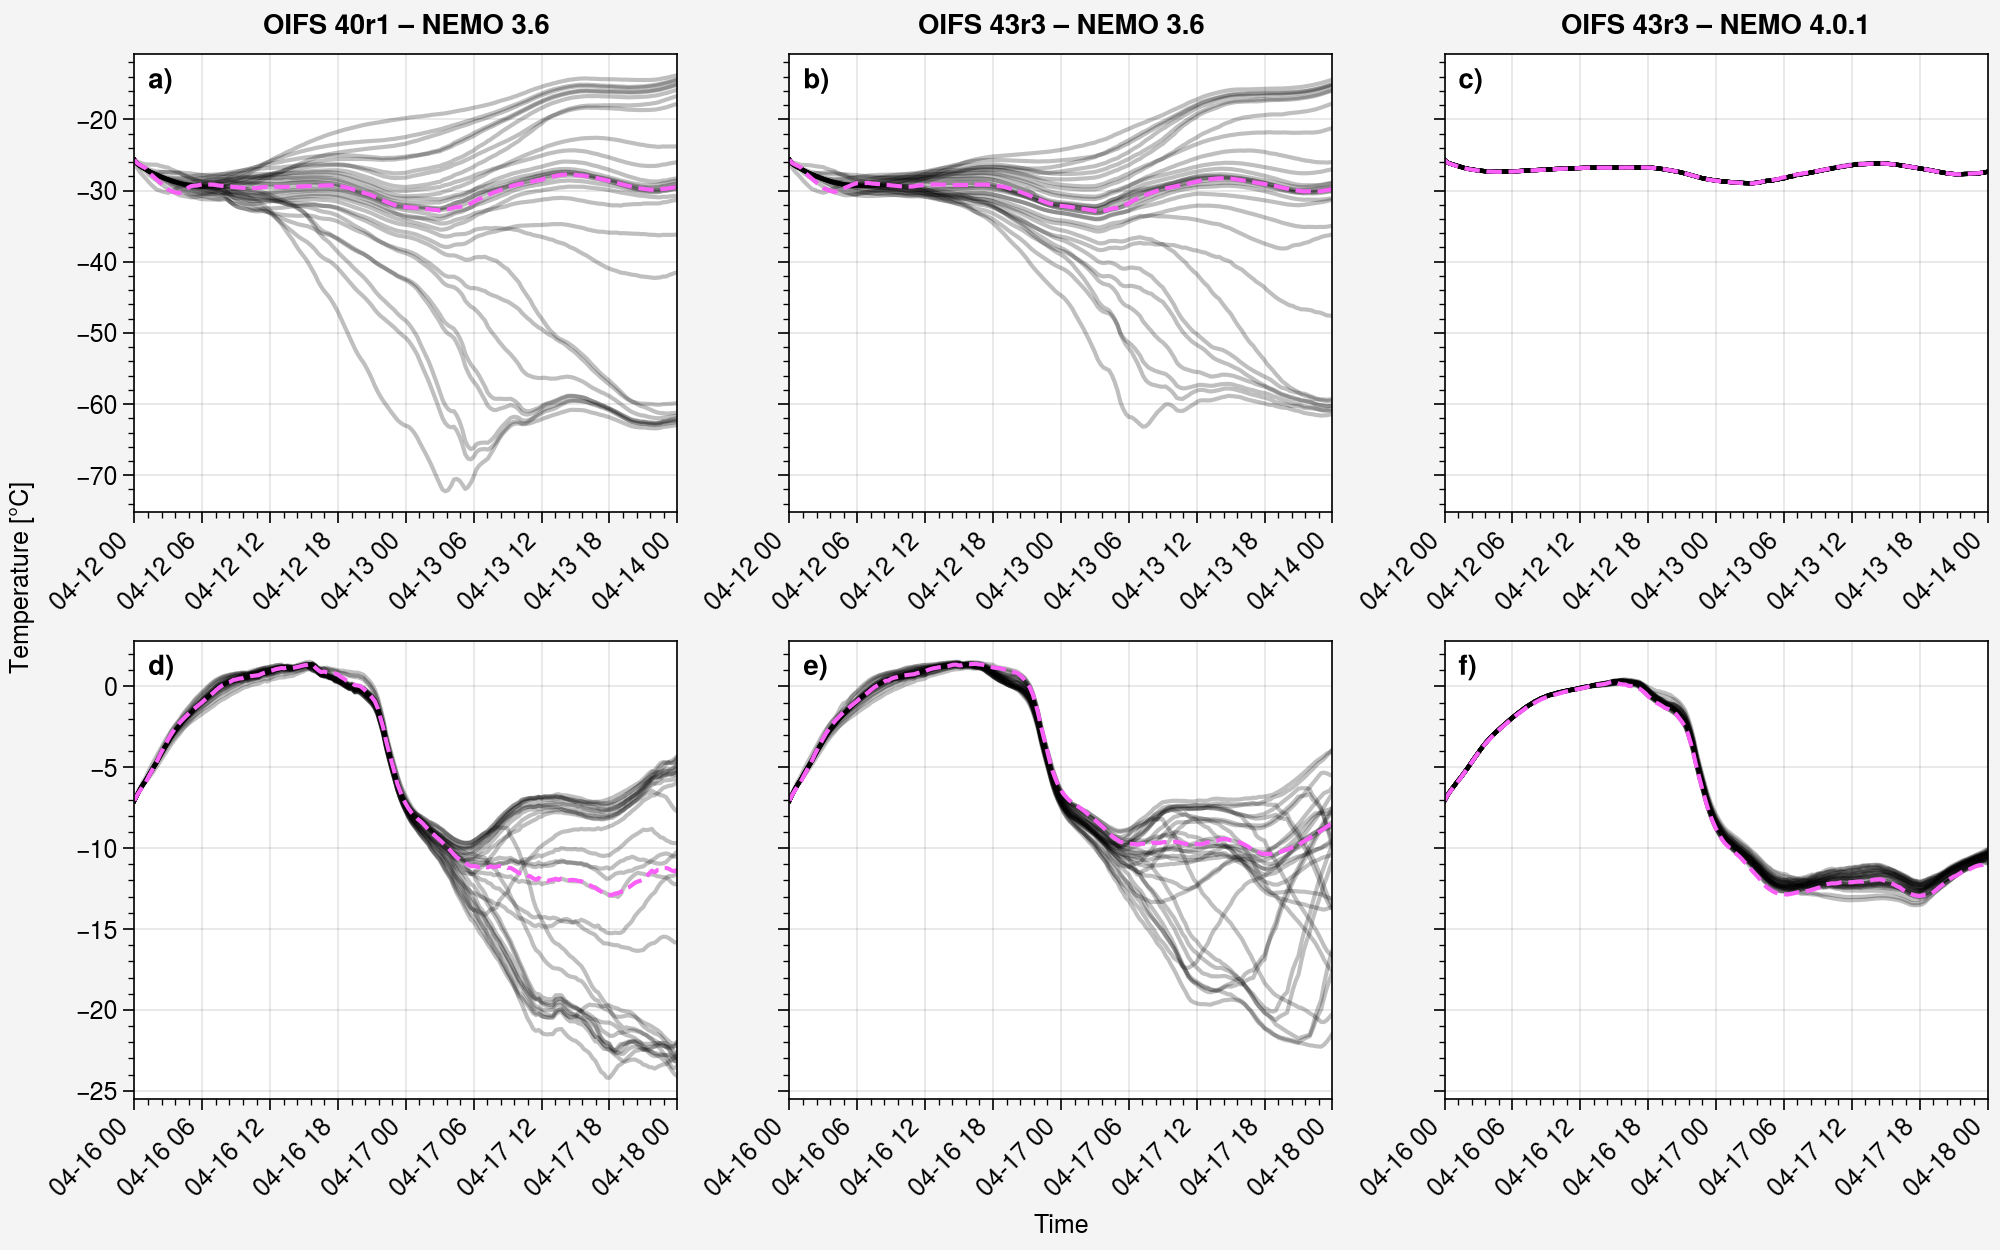

In [54]:
axis_settings = {
    "ylabel": "Temperature [°C]\n",
    "xlabel": "Time",
    "xrotation": 45,
}

fig, axs = pplt.subplots(
    nrows=2, ncols=3, width="80em", height="50em", sharex=1, sharey=3
)

for oifs_progvar, ax in zip(oifs_progvars_cold, axs[:3]):
    plot_all_iterates(oifs_progvar.t[:, :, -1] - 273.15, ax, **axis_settings)
    ax.format(
        xticklabels=None,
    )


for oifs_progvar, ax in zip(oifs_progvars_warm, axs[3:]):
    plot_all_iterates(oifs_progvar.t[:, :, -1] - 273.15, ax, **axis_settings)

axs.format(abc="a)", toplabels=titles, abcloc="ul")
# fig.format(suptitle="Atmospheric Temperature at 10m")
fig.savefig("top_compare_model_versions.pdf")

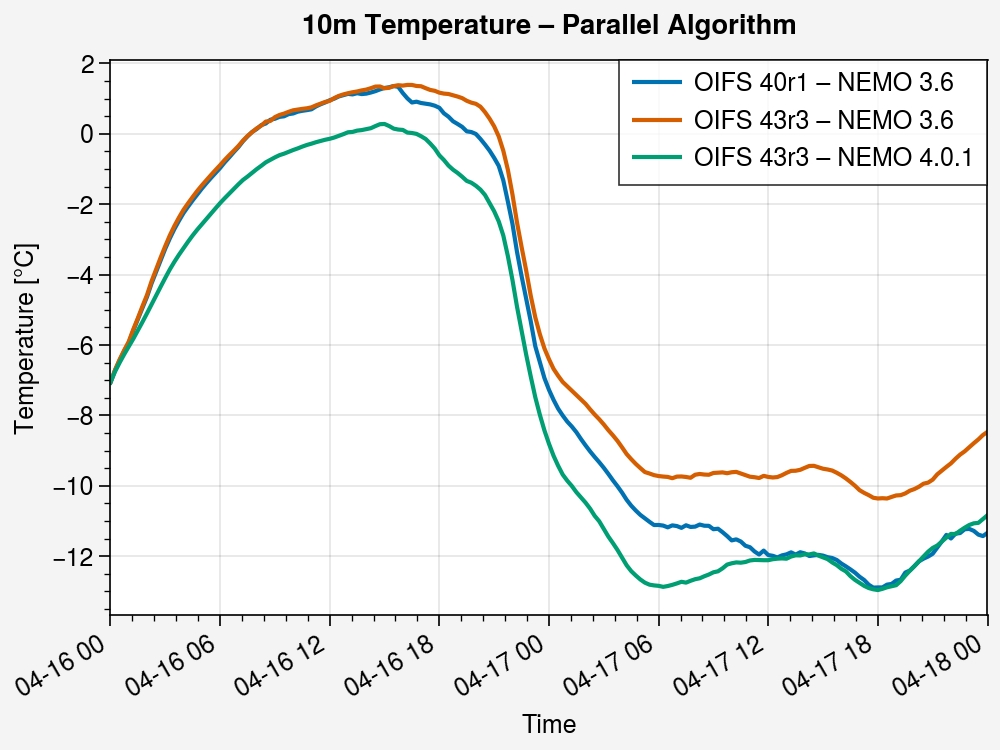

In [ ]:
axis_settings = {
    "ylabel": "Temperature [°C]",
    "xlabel": "Time",
    "xrotation": 30,
}

fig, ax = pplt.subplots(width="40em", height="30em")

for oifs_progvar, title in zip(oifs_progvars_warm, titles):
    ax.plot(oifs_progvar.t[0, :, -1] - 273.15, label=title)
ax.format(**axis_settings)
ax.legend(ncols=1)

fig.format(suptitle="10m Temperature – Parallel Algorithm")
fig.savefig("top_warm_parallel_comparison.pdf")

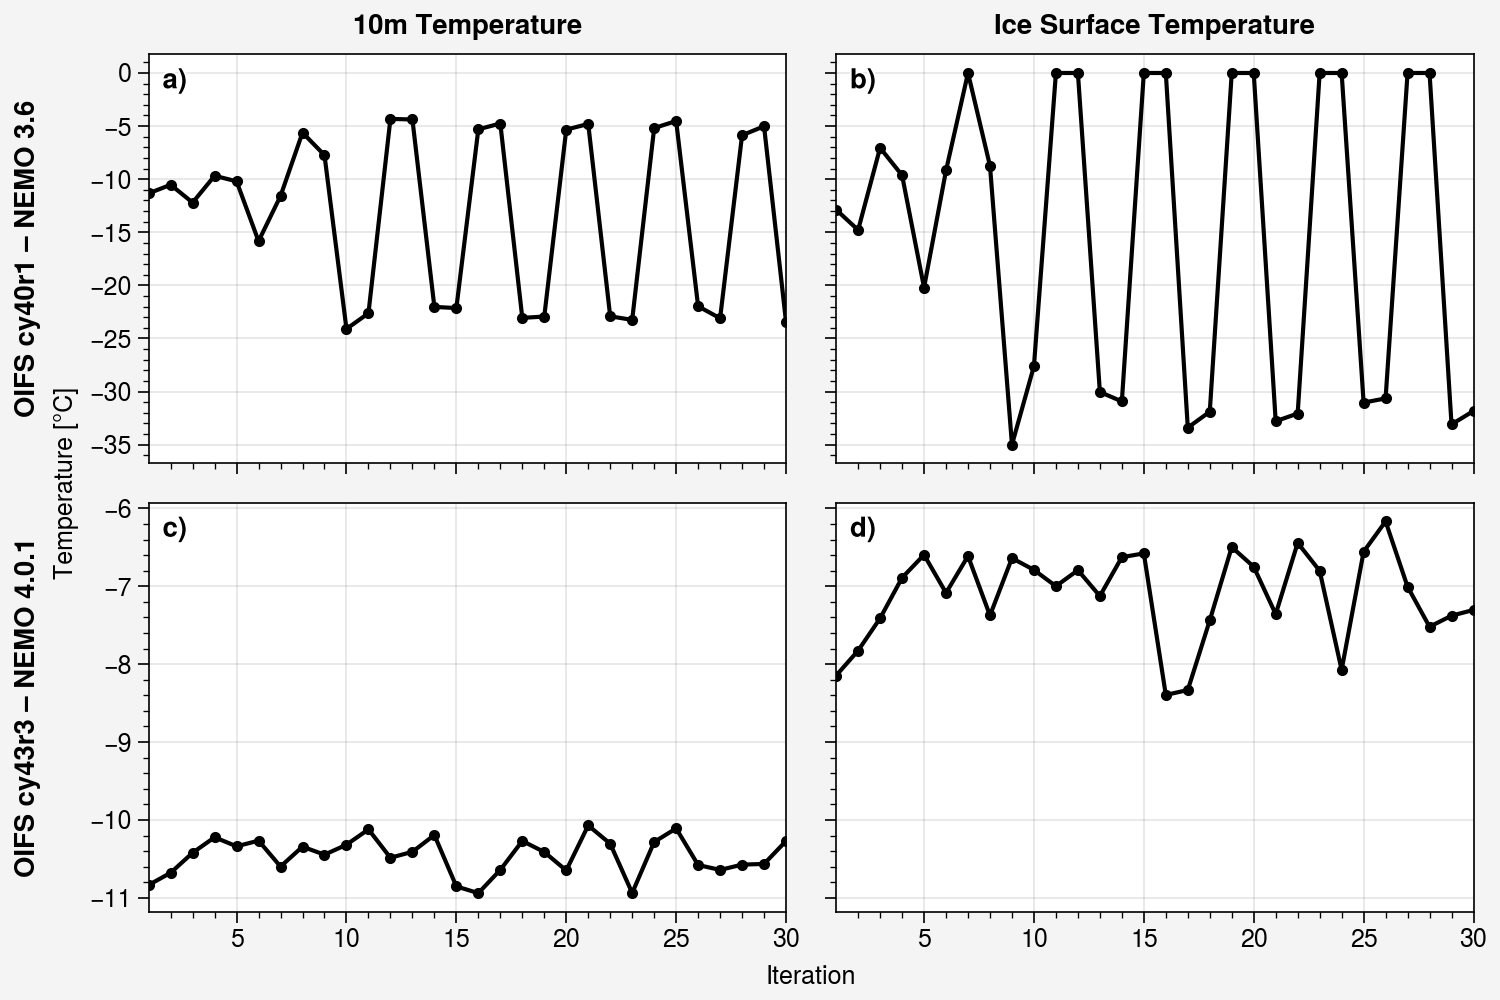

In [51]:
fig, axs = pplt.subplots(width="60em", height="40em", nrows=2, ncols=2, sharey=3)

ax = axs[0]
ax.plot(oifs_progvars_warm[0].t.isel(time=-1, nlev=-1) - 273.15, color="k", marker=".")
ax.format(
    ylabel="Temperature [°C]",
    xlabel="Iteration",
    xlim=[1, 30],
)

ax = axs[1]
ax.plot(nemo_ices_warm[0].icest.isel(time=-1), color="k", marker=".")
ax.format(
    ylabel="Temperature [°C]",
    xlabel="Iteration",
    xlim=[1, 30],
)

ax = axs[2]
ax.plot(oifs_progvars_warm[2].t.isel(time=-1, nlev=-1) - 273.15, color="k", marker=".")
ax.format(
    ylabel="Temperature [°C]",
    xlabel="Iteration",
    xlim=[1, 30],
)

ax = axs[3]
ax.plot(nemo_ices_warm[2].icettop.isel(time=-1), color="k", marker=".")
ax.format(
    ylabel="Temperature [°C]",
    xlabel="Iteration",
    xlim=[1, 30],
)

axs.format(
    leftlabels=("OIFS cy40r1 – NEMO 3.6", "OIFS cy43r3 – NEMO 4.0.1"),
    toplabels=("10m Temperature", "Ice Surface Temperature"),
    abc="a)",
    abcloc="ul",
)
fig.savefig("top_oscillations_model_versions.pdf")